## project name: 
## Predicting the Best Time to Call Customers Using Machine Learning

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.stats import skew, zscore

In [3]:
# 🔹 Step 1: Load the data
df = pd.read_csv(r"D:\DATA\DOC\6th june\call_center_data.csv")
df['call_time'] = pd.to_datetime(df['call_time'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   call_time                      100000 non-null  datetime64[ns]
 1   hour                           100000 non-null  int64         
 2   day_of_week                    100000 non-null  int64         
 3   is_weekend                     100000 non-null  int64         
 4   month                          100000 non-null  int64         
 5   time_since_last_call           95054 non-null   float64       
 6   customer_id                    100000 non-null  int64         
 7   customer_age                   100000 non-null  int64         
 8   occupation                     97043 non-null   object        
 9   city                           100000 non-null  object        
 10  gender                         98088 non-null   object        
 11  l

In [5]:
df.head()

,call_time,hour,day_of_week,is_weekend,month,time_since_last_call,customer_id,customer_age,occupation,city,gender,loan_amount,days_overdue,loan_type,payment_history,last_call_outcome,num_prev_calls,time_since_last_answered_call,call_answered
0,2024-06-22 15:51:06.225508,15,5,1,6,25.59,58720258,33,Unemployed,Tier-2,Female,37819.58,15,MHF Loan,2.0,Answered,3,0.04,1
1,2024-02-29 23:54:03.170686,23,3,0,2,93.35,81002507,24,Self-Employed,Tier-2,Male,112075.94,13,MHF Loan,1.0,Not Answered,5,0.76,0
2,2024-08-31 20:50:53.546622,20,5,1,8,16.62,14417935,25,Homemaker,Tier-3,Male,32426.35,26,MHF Loan,2.0,Answered,4,NaN,1
3,2024-04-23 10:38:59.025369,10,1,0,4,56.37,20185105,49,Retired,Tier-2,Female,36151.33,1,MHF Loan,2.0,Answered,4,0.03,1
4,2024-08-31 20:40:52.133514,20,5,1,8,119.56,93061138,33,Homemaker,Tier-3,Female,32704.88,10,MHF Loan,1.0,Answered,2,0.01,1


In [6]:
df.isna().sum()

call_time                            0
hour                                 0
day_of_week                          0
is_weekend                           0
month                                0
time_since_last_call              4946
customer_id                          0
customer_age                         0
occupation                        2957
city                                 0
gender                            1912
loan_amount                          0
days_overdue                         0
loan_type                            0
payment_history                   4051
last_call_outcome                  979
num_prev_calls                       0
time_since_last_answered_call    10248
call_answered                        0
dtype: int64

## preprocessing step

In [7]:
# 🔹 Step 2: Fill missing values based on skewness
def fill_missing_numerical(col):
    if skew(df[col].dropna()) > 1:
        return df[col].fillna(df[col].median())
    else:
        return df[col].fillna(df[col].mean())

num_cols = ['time_since_last_call', 'payment_history', 'time_since_last_answered_call']
for col in num_cols:
    df[col] = fill_missing_numerical(col)

cat_cols = ['occupation', 'gender', 'last_call_outcome']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
# 🔹 Step 3: Encode categorical features (exclude last_call_outcome for now to avoid leakage)
le_dict = {}
for col in ['occupation', 'city', 'gender']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [9]:
df.isna().sum()

call_time                        0
hour                             0
day_of_week                      0
is_weekend                       0
month                            0
time_since_last_call             0
customer_id                      0
customer_age                     0
occupation                       0
city                             0
gender                           0
loan_amount                      0
days_overdue                     0
loan_type                        0
payment_history                  0
last_call_outcome                0
num_prev_calls                   0
time_since_last_answered_call    0
call_answered                    0
dtype: int64

## correlation analysis

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr


In [11]:
# Numeric columns (exclude target)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('call_answered')

In [12]:
# Categorical columns
cat_cols = ['occupation', 'last_call_outcome', 'city', 'gender']

In [13]:
# Point-biserial correlation for numeric features
print("Point-biserial correlations (numeric features vs call_answered):")
for col in num_cols:
    corr, pval = pointbiserialr(df[col], df['call_answered'])
    print(f"{col}: corr={corr:.3f}, p-value={pval:.3e}")

Point-biserial correlations (numeric features vs call_answered):
hour: corr=0.087, p-value=3.981e-166
day_of_week: corr=0.314, p-value=0.000e+00
is_weekend: corr=0.355, p-value=0.000e+00
month: corr=-0.001, p-value=8.178e-01
time_since_last_call: corr=-0.003, p-value=3.890e-01
customer_id: corr=-0.003, p-value=3.987e-01
customer_age: corr=0.223, p-value=0.000e+00
occupation: corr=-0.075, p-value=2.121e-125
city: corr=0.146, p-value=0.000e+00
gender: corr=-0.003, p-value=3.789e-01
loan_amount: corr=0.000, p-value=9.687e-01
days_overdue: corr=-0.136, p-value=0.000e+00
payment_history: corr=-0.022, p-value=2.850e-12
num_prev_calls: corr=-0.127, p-value=0.000e+00
time_since_last_answered_call: corr=-0.580, p-value=0.000e+00


In [14]:
# Encode categorical columns
df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

In [15]:
# Mutual information for categorical features
print("\nMutual Information (categorical features vs call_answered):")
mi_scores = mutual_info_classif(df_encoded[cat_cols], df_encoded['call_answered'], discrete_features=True)
for col, mi in zip(cat_cols, mi_scores):
    print(f"{col}: MI={mi:.3f}")


Mutual Information (categorical features vs call_answered):
occupation: MI=0.047
last_call_outcome: MI=0.642
city: MI=0.011
gender: MI=0.000


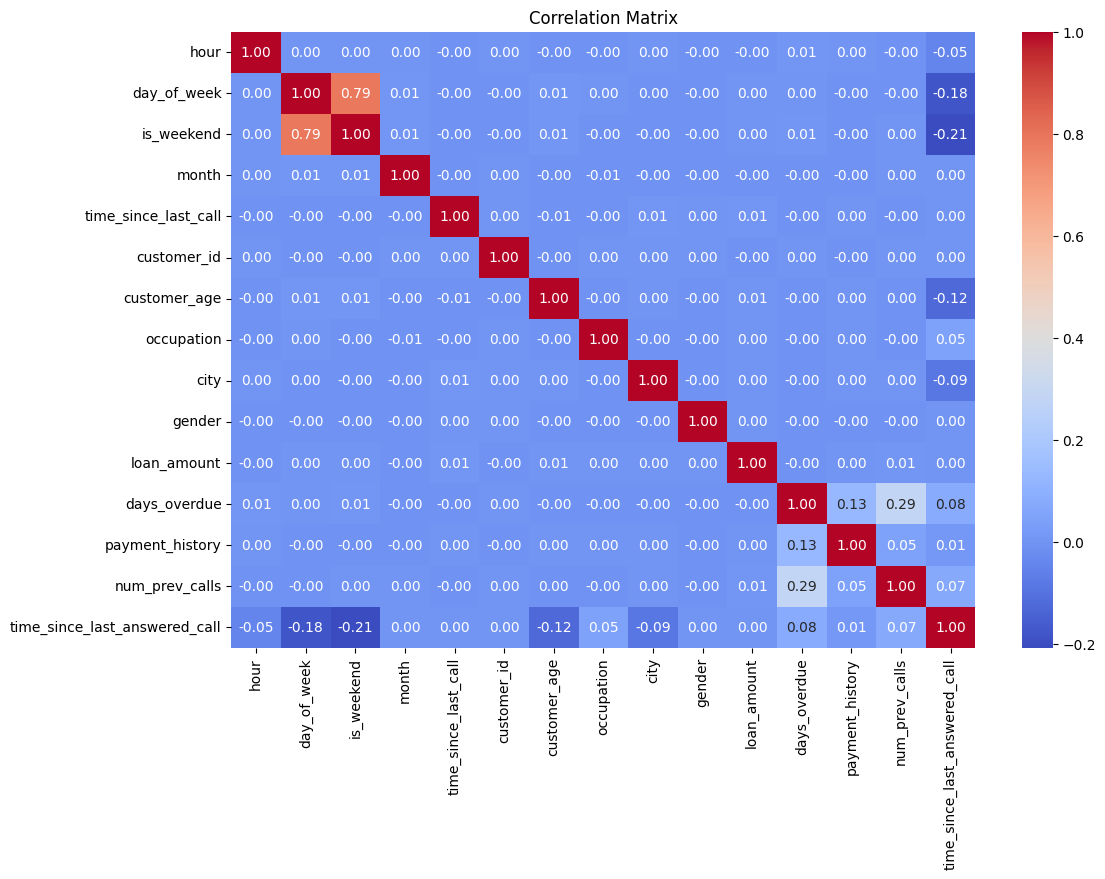

In [16]:
# Plot correlation heatmap (optional)
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## data imbalance check

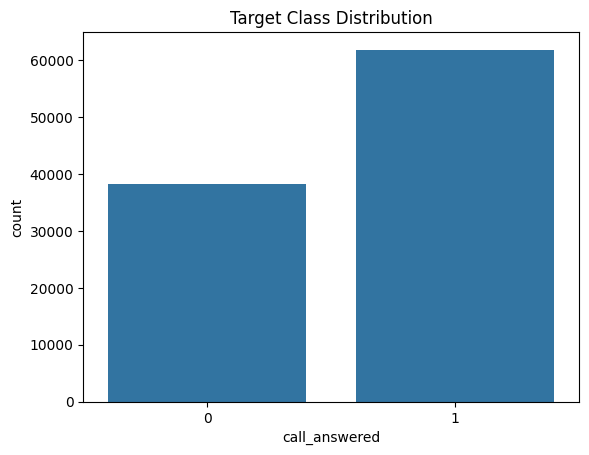

Class 0 count: 38185, Class 1 count: 61815, Imbalance Ratio: 0.62


In [17]:
# 🔹 Step 5: Check class imbalance visually and ratio
sns.countplot(data=df, x='call_answered')
plt.title("Target Class Distribution")
plt.show()

count_0 = (df['call_answered'] == 0).sum()
count_1 = (df['call_answered'] == 1).sum()
imbalance_ratio = count_0 / count_1
print(f"Class 0 count: {count_0}, Class 1 count: {count_1}, Imbalance Ratio: {imbalance_ratio:.2f}")


In [18]:
features = [
    'hour',
    'day_of_week',
    'is_weekend',
    'days_overdue',
    'num_prev_calls',
    'occupation',
    'customer_age'
]

X = df[features]
y = df['call_answered']


## Train test splitt

In [19]:
# 🔹 Step 7: Train-test split BEFORE SMOTE and outlier removal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# 🔹 Step 8: Apply SMOTE ONLY if imbalance ratio is significant (>1.5)
if imbalance_ratio > 1.5:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE - Training class distribution:\n{pd.Series(y_train).value_counts()}")


## outlier detection and removal

In [21]:
# 🔹 Step 9: Outlier detection & removal on training data only
num_features_for_outliers = ['days_overdue', 'customer_age']    

# Reset index to avoid issues after filtering
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Compute Z-scores and apply mask
z_scores = np.abs(zscore(X_train[num_features_for_outliers]))
mask = (z_scores < 3).all(axis=1)

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Training data shape after outlier removal: {X_train.shape}")


Training data shape after outlier removal: (78375, 7)


## model building

In [22]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=200,
                       random_state=42)

## model evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# 🔹 Step 11: Model Evaluation
y_pred = model.predict(X_test)

# 📊 Metrics
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🎯 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("🔵 ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      7637
           1       0.91      0.97      0.94     12363

    accuracy                           0.92     20000
   macro avg       0.93      0.91      0.92     20000
weighted avg       0.92      0.92      0.92     20000

🎯 Confusion Matrix:
 [[ 6469  1168]
 [  379 11984]]
🔵 ROC AUC Score: 0.9082021871853792
✅ Accuracy Score: 0.92265


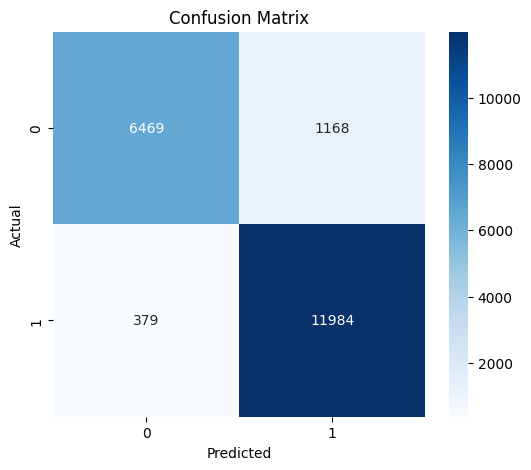

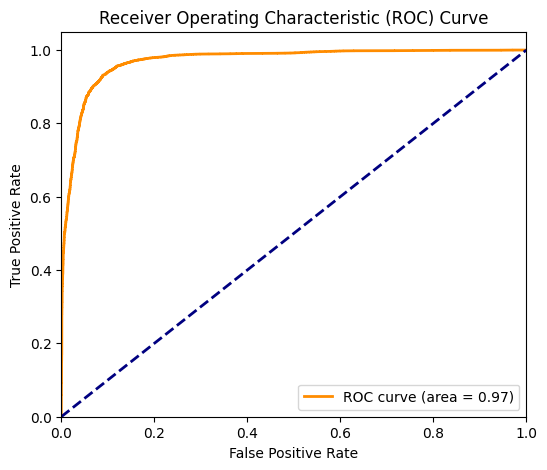

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve Plot
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


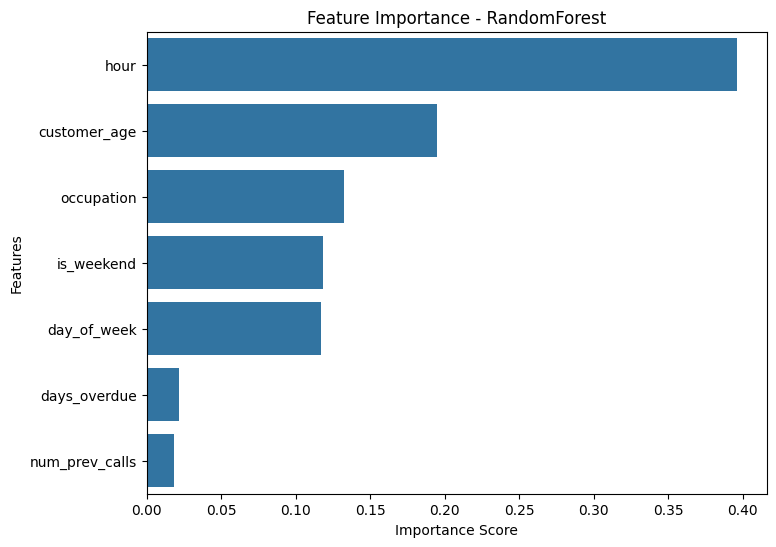

Feature Importances:
 hour              0.396137
customer_age      0.194970
occupation        0.132542
is_weekend        0.118401
day_of_week       0.117262
days_overdue      0.022079
num_prev_calls    0.018609
dtype: float64


In [25]:
import pandas as pd

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance - RandomForest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

print("Feature Importances:\n", feature_importances)


## predicting the best time to call the customer based on the new customer details

In [26]:
def predict_best_call_time(customer_data, model, hours_to_test=range(8, 21)):
    """
    Predict the best hour to call a customer.
    
    Args:
        customer_data: dict of customer features (excluding hour)
        model: trained model
        hours_to_test: hours to test (8 to 20 by default)

    Returns:
        Tuple(best_hour, best_probability)
    """
    results = []

    for hour in hours_to_test:
        entry = customer_data.copy()
        entry['hour'] = hour
        df_entry = pd.DataFrame([entry])[model.feature_names_in_]
        prob = model.predict_proba(df_entry)[0][1]
        results.append((hour, prob))

    best_hour, best_prob = max(results, key=lambda x: x[1])
    return best_hour, best_prob


In [27]:
new_customers = [
    {
        'day_of_week': 4, 'is_weekend': 1, 'days_overdue': 12,
        'num_prev_calls': 5, 'occupation': 2, 'customer_age': 58
    },
    {
        'day_of_week': 3, 'is_weekend': 0, 'days_overdue': 0,
        'num_prev_calls': 0, 'occupation': 5, 'customer_age': 45
    },
    {
        'day_of_week': 6, 'is_weekend': 1, 'days_overdue': 5,
        'num_prev_calls': 3, 'occupation': 1, 'customer_age': 32
    },
    {
        'day_of_week': 1, 'is_weekend': 0, 'days_overdue': 10,
        'num_prev_calls': 5, 'occupation': 0, 'customer_age': 52
    }
]


In [28]:
for i, customer in enumerate(new_customers, 1):
    best_hour, best_prob = predict_best_call_time(customer, model)
    print(f"🧑 Customer {i}: Best time to call = {best_hour}:00, Probability = {best_prob*100:.2f}%")


🧑 Customer 1: Best time to call = 17:00, Probability = 97.55%
🧑 Customer 2: Best time to call = 16:00, Probability = 86.50%
🧑 Customer 3: Best time to call = 9:00, Probability = 97.92%
🧑 Customer 4: Best time to call = 12:00, Probability = 97.92%


In [ ]:
import joblib
# Save the trained model to a .pkl file
joblib.dump(model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


In [30]:
!where python

d:\DATA\DOC\6th june\.venv\Scripts\python.exe
C:\Users\419376\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\419376\AppData\Local\Microsoft\WindowsApps\python.exe


In [31]:
from transformers.models.auto.configuration_auto import CONFIG_MAPPING
print(CONFIG_MAPPING.keys())

d:\DATA\DOC\6th june\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['albert', 'align', 'altclip', 'aria', 'aria_text', 'audio-spectrogram-transformer', 'autoformer', 'aya_vision', 'bamba', 'bark', 'bart', 'beit', 'bert', 'bert-generation', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bit', 'bitnet', 'blenderbot', 'blenderbot-small', 'blip', 'blip-2', 'blip_2_qformer', 'bloom', 'bridgetower', 'bros', 'camembert', 'canine', 'chameleon', 'chinese_clip', 'chinese_clip_vision_model', 'clap', 'clip', 'clip_text_model', 'clip_vision_model', 'clipseg', 'clvp', 'code_llama', 'codegen', 'cohere', 'cohere2', 'colpali', 'conditional_detr', 'convbert', 'convnext', 'convnextv2', 'cpmant', 'csm', 'ctrl', 'cvt', 'd_fine', 'dab-detr', 'dac', 'data2vec-audio', 'data2vec-text', 'data2vec-vision', 'dbrx', 'deberta', 'deberta-v2', 'decision_transformer', 'deepseek_v3', 'deformable_detr', 'deit', 'depth_anything', 'depth_pro', 'deta', 'detr', 'diffllama', 'dinat', 'dinov2', 'dinov2_with_registers', 'distilbert', 'donut-swin', 'dpr', 'dpt', 'efficientformer', 'efficientnet', '

In [33]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "microsoft/phi-1_5"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)

In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5")

d:\DATA\DOC\6th june\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\419376\.cache\huggingface\hub\models--microsoft--phi-1_5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "microsoft/phi-1_5"  # Official Hugging Face ID
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def load_lamini_model():
    model_id = "MBZUAI/LaMini-T5-738M"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    return tokenizer, model

tokenizer, lamini_model = load_lamini_model()
print("✅ LaMini-T5 model loaded")


✅ LaMini-T5 model loaded


d:\DATA\DOC\6th june\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\419376\.cache\huggingface\hub\models--MBZUAI--LaMini-T5-738M. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# import pandas as pd
# import numpy as np

# # Generate synthetic input data
# np.random.seed(42)
# num_rows = 20

# data = {
#     "customer_id": [f"CUST{1000+i}" for i in range(num_rows)],
#     "day_of_week": np.random.randint(0, 7, num_rows),
#     "is_weekend": np.random.randint(0, 2, num_rows),
#     "month": np.random.randint(1, 13, num_rows),
#     "time_since_last_call": np.round(np.random.uniform(1, 30, num_rows), 1),
#     "customer_age": np.random.randint(22, 65, num_rows),
#     "occupation": np.random.choice(["Daily wage", "Private job", "Farmer", "Unemployed", "Small business"], num_rows),
#     "city": np.random.choice(["Metro", "Tier-2", "Tier-3"], num_rows),
#     "gender": np.random.choice(["Male", "Female"], num_rows),
#     "loan_amount": np.round(np.random.uniform(10000, 50000, num_rows), 2),
#     "days_overdue": np.random.randint(1, 90, num_rows),
#     "payment_history": np.random.choice(["Good", "Irregular", "Poor"], num_rows),
#     "last_call_outcome": np.random.choice(["Answered", "Missed", "Busy", "Switched off"], num_rows),
#     "num_prev_calls": np.random.randint(1, 10, num_rows),
#     "time_since_last_answered_call": np.round(np.random.uniform(1, 45, num_rows), 1)
# }

# df = pd.DataFrame(data)
# df.to_excel("sample_input_for_streamlit.xlsx", index=False)


In [2]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Number of sample customers
num_samples = 20

# Generate synthetic customer data
data = {
    "customer_id": [f"CUST{100000 + i}" for i in range(num_samples)],
    "day_of_week": np.random.randint(0, 7, size=num_samples),
    "is_weekend": np.random.choice([0, 1], size=num_samples),
    "month": np.random.randint(1, 13, size=num_samples),
    "time_since_last_call": np.round(np.random.uniform(0.5, 96, size=num_samples), 2),
    "customer_age": np.random.randint(22, 65, size=num_samples),
    "occupation": np.random.choice(["Unemployed", "Daily wage", "Homemaker", "Private job", "Farmer", "Small business"], size=num_samples),
    "city": np.random.choice(["Metro", "Tier-2", "Tier-3"], size=num_samples),
    "gender": np.random.choice(["Male", "Female", "Other"], size=num_samples),
    "loan_amount": np.round(np.random.uniform(10000, 150000, size=num_samples), 2),
    "days_overdue": np.random.randint(1, 91, size=num_samples),
    "payment_history": np.round(np.random.uniform(0.0, 4.0, size=num_samples), 1),
    "last_call_outcome": np.random.choice(["Answered", "Busy", "Not Answered", "Voicemail"], size=num_samples),
    "num_prev_calls": np.random.randint(1, 11, size=num_samples),
    "time_since_last_answered_call": np.round(np.random.uniform(0.1, 72, size=num_samples), 2)
}

# Create DataFrame
input_df = pd.DataFrame(data)

# Save to Excel
input_df.to_excel("sample_input_for_streamlit.xlsx", index=False)
print("✅ File saved: sample_input_for_streamlit.xlsx")


✅ File saved: sample_input_for_streamlit.xlsx
